# Using the ml4qc package for a specific example analysis ("CATI1")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI1".

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **duration** - Total number of seconds spent editing form
* **instance_time** - Timestamp in an unusual format; will be dropped
* **TA** - Relative path to text audit `.csv` file
* **pct_conversation** - Percent of form-editing time when conversation was detected ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones (b/c storage and text audit formats don't automatically include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati1/cati1.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate      6032
starttime           6032
endtime             6031
duration            6032
instance_time       6032
TA                  6032
pct_conversation    6031
review_status       6032
review_quality      6032
dtype: int64

Submission DataFrame review status and quality:
APPROVED    5800
REJECTED     232
Name: review_status, dtype: Int64
OKAY    2992
GOOD    2761
POOR     279
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         1244960
duration_s    1244960
visited_s     1244960
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                              6032
starttime                                                                                   6032
endtime                                                                                     6031
duration                                                                                    6032

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict.

In [34]:
from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.9

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["instance_time", "SubmissionDate", "starttime", "endtime", "duration", "TA"], axis=1).copy(deep=True)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
# target_description = "APPROVED submissions classified as GOOD quality"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 0), axis=1)
target_description = "REJECTED submissions"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR submissions"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
target_df = pd.DataFrame(classes_df["target"])

# create SurveyML object with 75% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=False, random_state=None, verbose=True, reweight_classes=True)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

numeric features: 6276
numeric_binary features: 2965
numeric_unit_interval features: 3305
numeric_other features: 6
datetime features: 0
other features: 2
  Starting training set shape: (4522, 6278)
Starting prediction set shape: (1508, 6278)
     Final training set shape: (4522, 464)
   Final prediction set shape: (1508, 464)


  Predicting: REJECTED submissions
       Model: Logistic regression

Running prediction model...

  Training set: (4522, 464) (157 positive)
Prediction set: (1508, 464)

      Train accuracy:  91.99%
     Train precision:  29.94%
           Train F-1:  0.46
 Prediction accuracy:  87.20%
Prediction precision:  13.58%
      Prediction F-1:  0.19
  Test ROC_AUC Score:  0.6


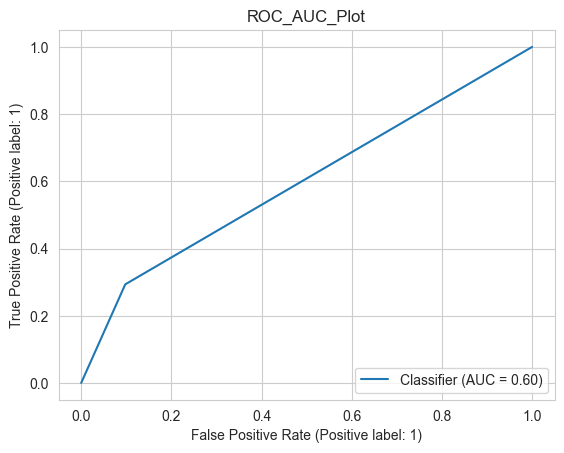

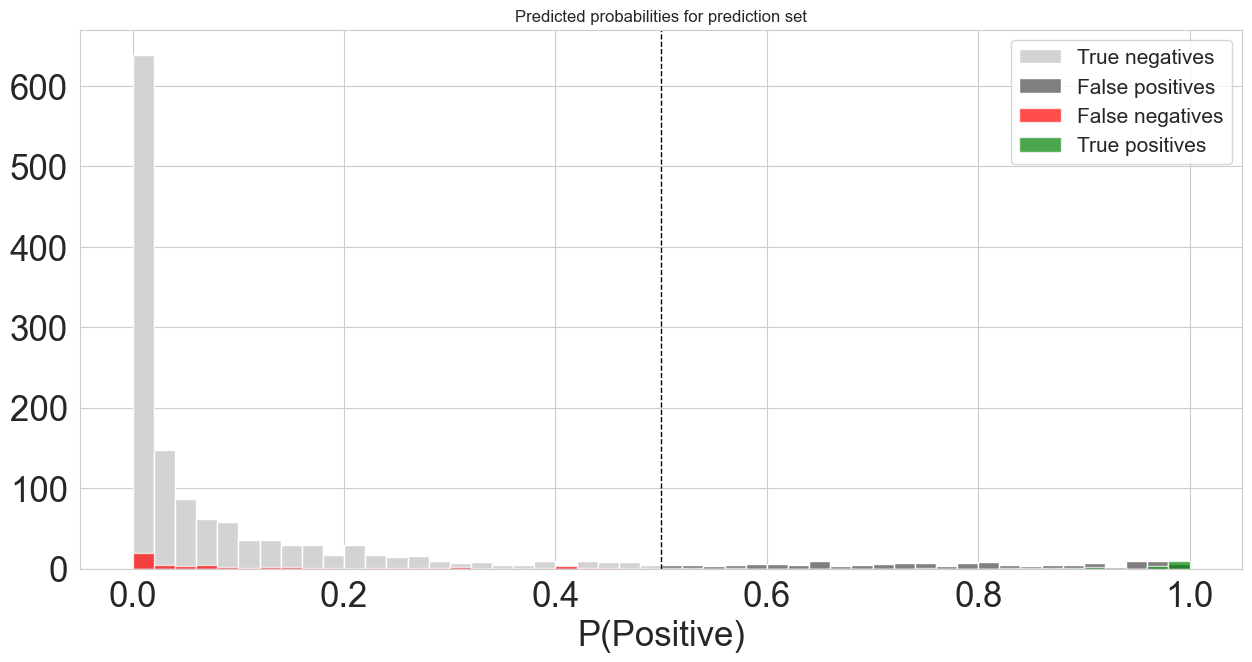

Test P(1) =  4.97%
Test P(1 | predicted 1) =  13.58%
Test P(1 | predicted 0) =  3.94%

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1433
           1       0.14      0.29      0.19        75

    accuracy                           0.87      1508
   macro avg       0.55      0.60      0.56      1508
weighted avg       0.92      0.87      0.89      1508



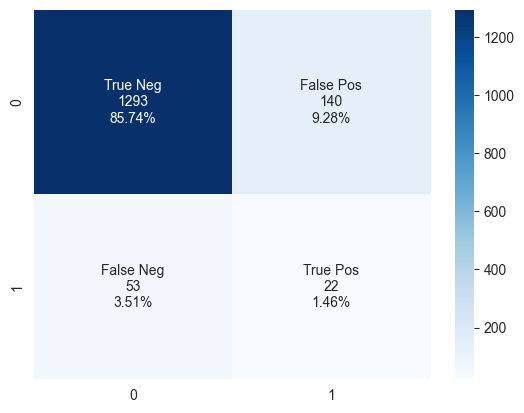

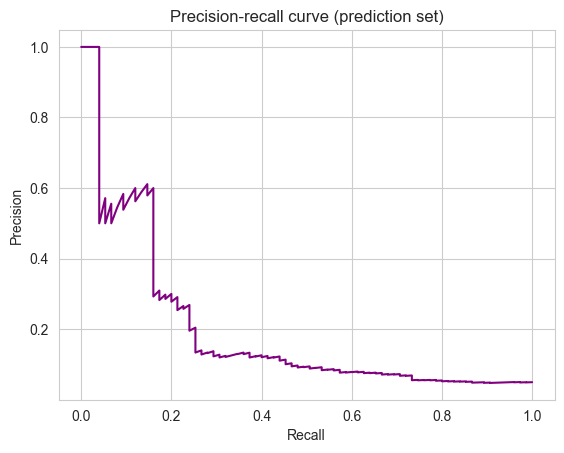

CPU times: user 4.56 s, sys: 668 ms, total: 5.22 s
Wall time: 2.28 s


In [35]:
%%time

model_description = "Logistic regression"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression(random_state=None, C=0.01, penalty='l2', max_iter=10000, class_weight=surveyml.class_weights)
predictions = surveyml.run_prediction_model(classifier_lr)
# surveyml.report_feature_importance(classifier_lr.coef_[0])

  Predicting: REJECTED submissions
       Model: Decision tree

Running prediction model...

  Training set: (4522, 464) (157 positive)
Prediction set: (1508, 464)

      Train accuracy:  92.48%
     Train precision:  31.59%
           Train F-1:  0.48
 Prediction accuracy:  85.54%
Prediction precision:  10.50%
      Prediction F-1:  0.15
  Test ROC_AUC Score:  0.57


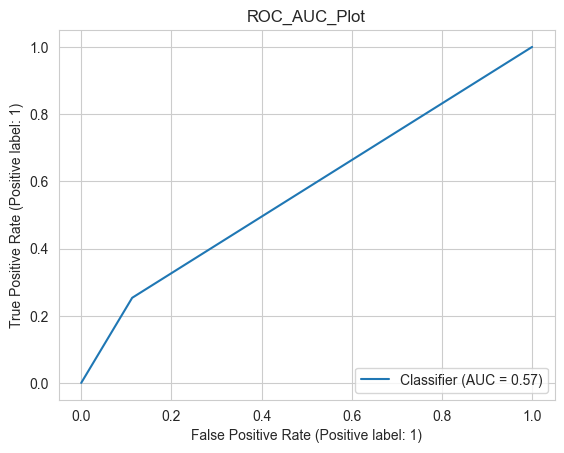

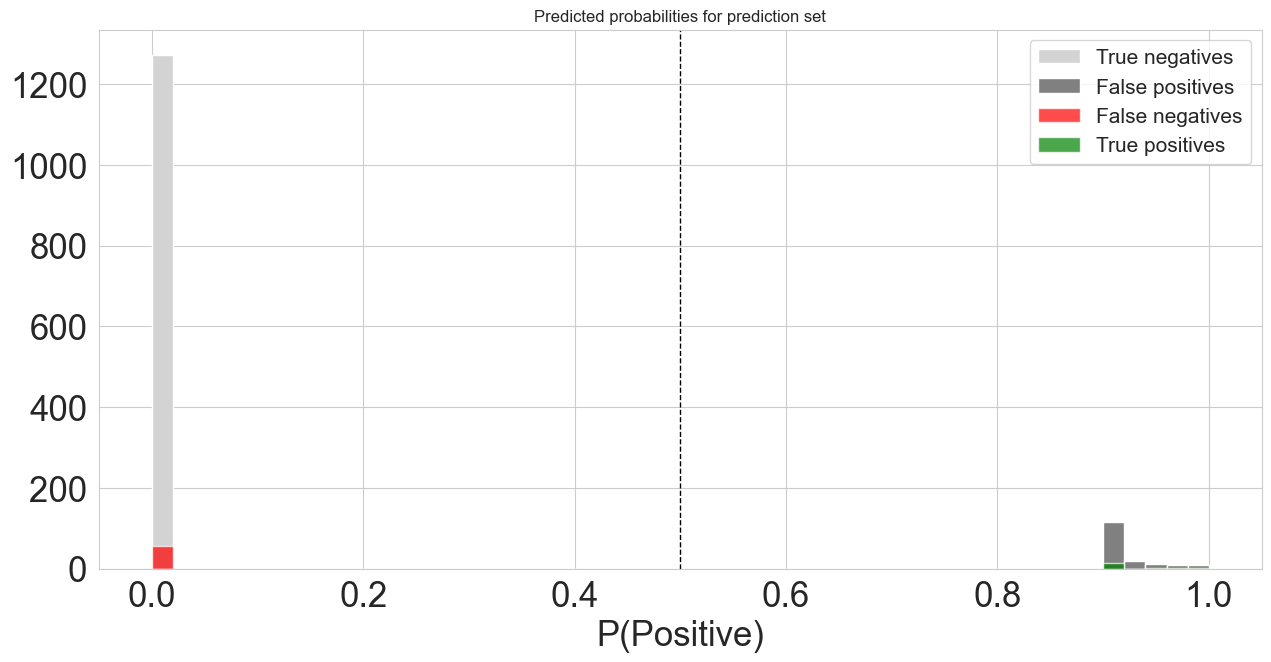

Test P(1) =  4.97%
Test P(1 | predicted 1) =  10.50%
Test P(1 | predicted 0) =  4.22%

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1433
           1       0.10      0.25      0.15        75

    accuracy                           0.86      1508
   macro avg       0.53      0.57      0.53      1508
weighted avg       0.92      0.86      0.88      1508



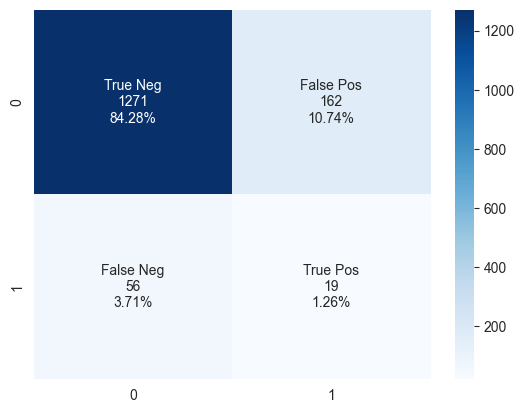

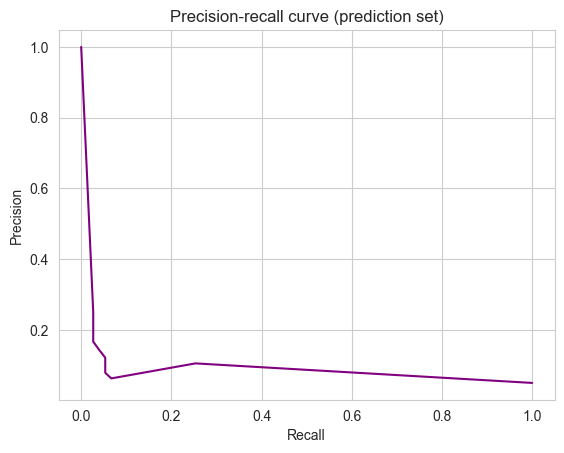

CPU times: user 3.67 s, sys: 233 ms, total: 3.9 s
Wall time: 3.31 s


In [36]:
%%time

model_description = "Decision tree"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(random_state=None, class_weight=surveyml.class_weights, max_depth=10, min_samples_leaf=2)
predictions = surveyml.run_prediction_model(classifier_dt)
# surveyml.report_feature_importance(classifier_dt.feature_importances_)

  Predicting: REJECTED submissions
       Model: Random forest

Running prediction model...

  Training set: (4522, 464) (157 positive)
Prediction set: (1508, 464)

      Train accuracy:  93.26%
     Train precision:  30.93%
           Train F-1:  0.44
 Prediction accuracy:  90.38%
Prediction precision:  23.08%
      Prediction F-1:  0.29
  Test ROC_AUC Score:  0.67


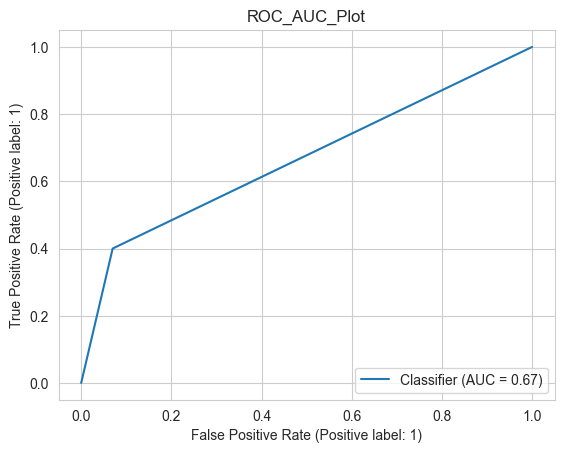

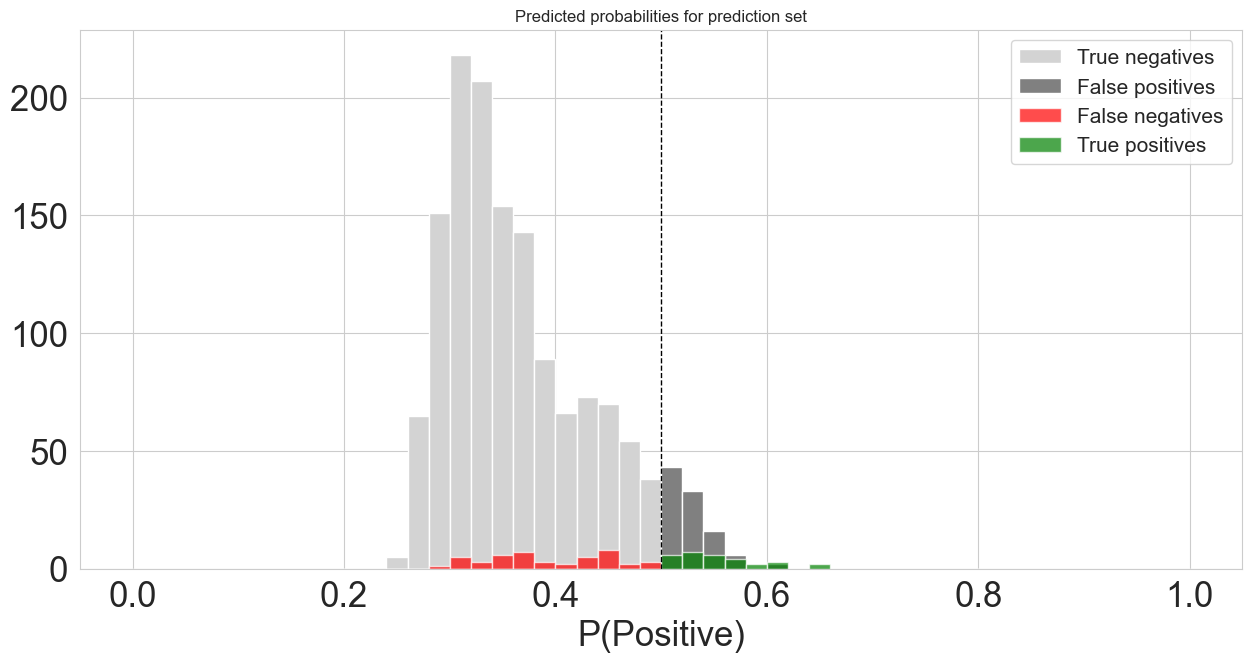

Test P(1) =  4.97%
Test P(1 | predicted 1) =  23.08%
Test P(1 | predicted 0) =  3.27%

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1433
           1       0.23      0.40      0.29        75

    accuracy                           0.90      1508
   macro avg       0.60      0.67      0.62      1508
weighted avg       0.93      0.90      0.92      1508



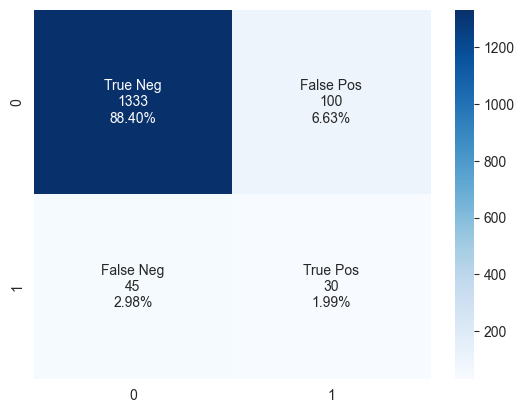

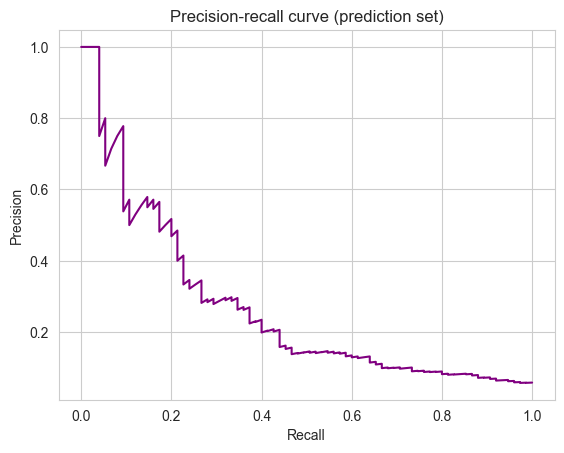

CPU times: user 23.9 s, sys: 1.12 s, total: 25 s
Wall time: 24.4 s


In [37]:
%%time

model_description = "Random forest"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=None, n_estimators=1000, class_weight="balanced", max_depth=3, min_samples_leaf=1)
predictions = surveyml.run_prediction_model(classifier_rf)
# surveyml.report_feature_importance(classifier_rf.feature_importances_)

  Predicting: REJECTED submissions
       Model: XGBoost

Running prediction model...

  Training set: (4522, 464) (157 positive)
Prediction set: (1508, 464)

      Train accuracy:  100.00%
     Train precision:  100.00%
           Train F-1:  1.0
 Prediction accuracy:  95.23%
Prediction precision:  61.54%
      Prediction F-1:  0.18
  Test ROC_AUC Score:  0.55


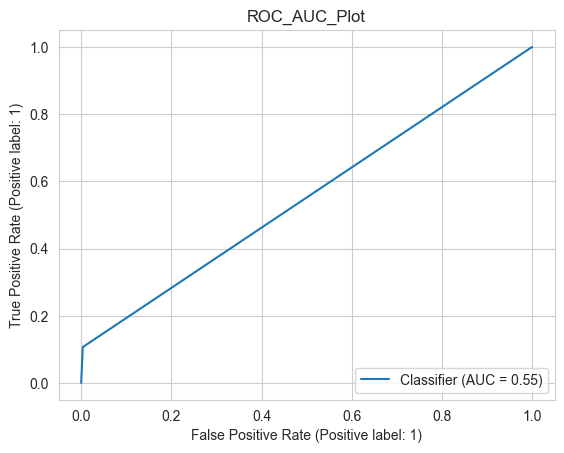

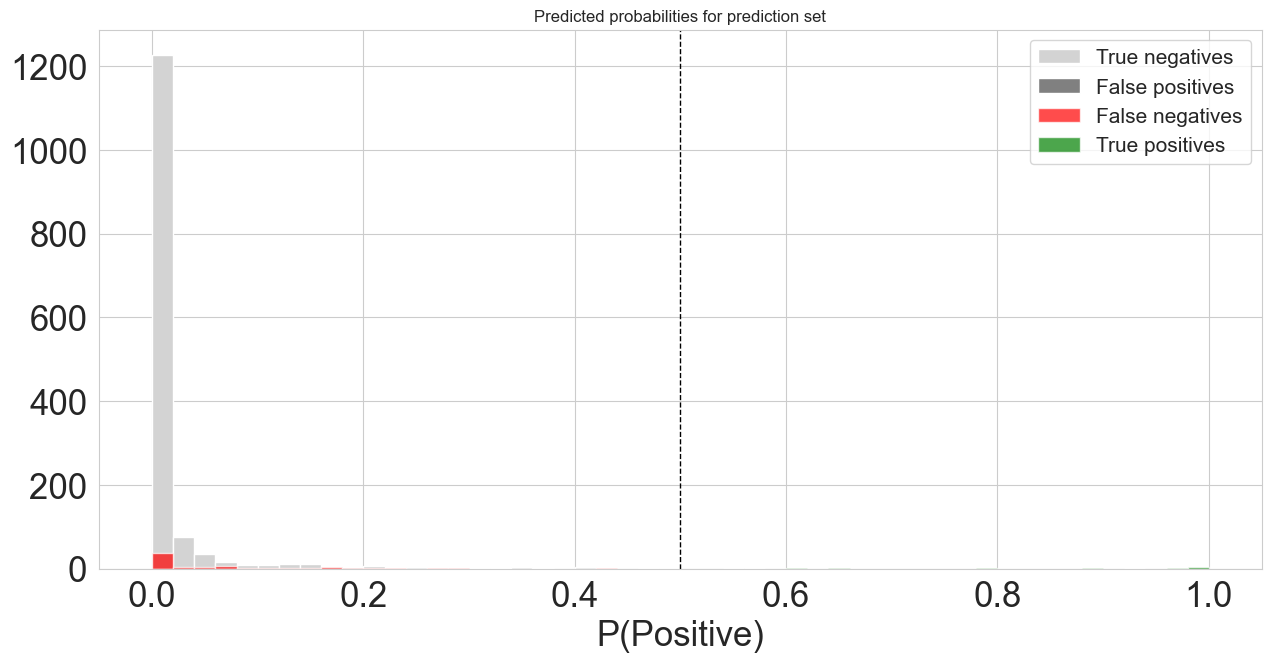

Test P(1) =  4.97%
Test P(1 | predicted 1) =  61.54%
Test P(1 | predicted 0) =  4.48%

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1433
           1       0.62      0.11      0.18        75

    accuracy                           0.95      1508
   macro avg       0.79      0.55      0.58      1508
weighted avg       0.94      0.95      0.94      1508



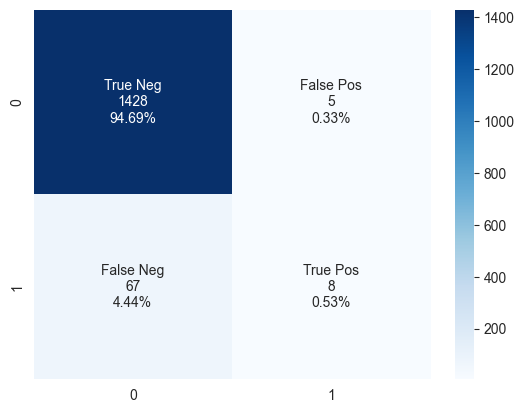

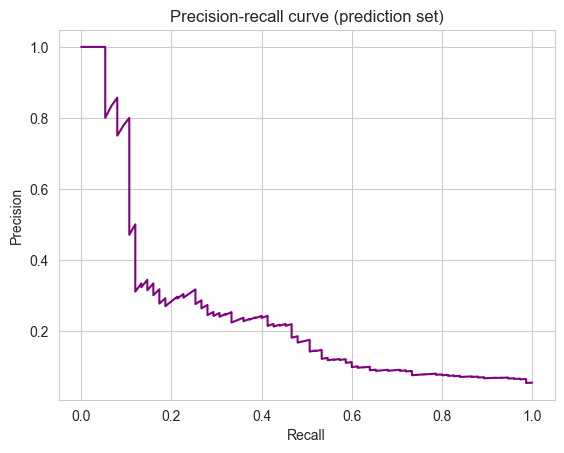

CPU times: user 41.7 s, sys: 885 ms, total: 42.6 s
Wall time: 6.36 s


In [38]:
%%time

model_description = "XGBoost"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

from xgboost import XGBClassifier

classifier_xb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', max_depth=3, scale_pos_weight=surveyml.neg_train/surveyml.pos_train, use_label_encoder=False)
predictions = surveyml.run_prediction_model(classifier_xb)
# surveyml.report_feature_importance(classifier_xb.feature_importances_)

  Predicting: REJECTED submissions
       Model: Neural network

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 464)               215760    
                                                                 
 dropout_8 (Dropout)         (None, 464)               0         
                                                                 
 dense_13 (Dense)            (None, 232)               107880    
                                                                 
 dropout_9 (Dropout)         (None, 232)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 233       
                                                                 
Total params: 323,873
Trainable params: 323,873
Non-trainable params: 0
_________________________________________________

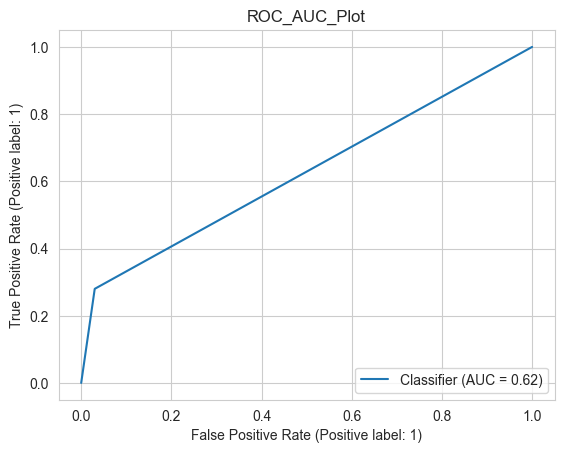

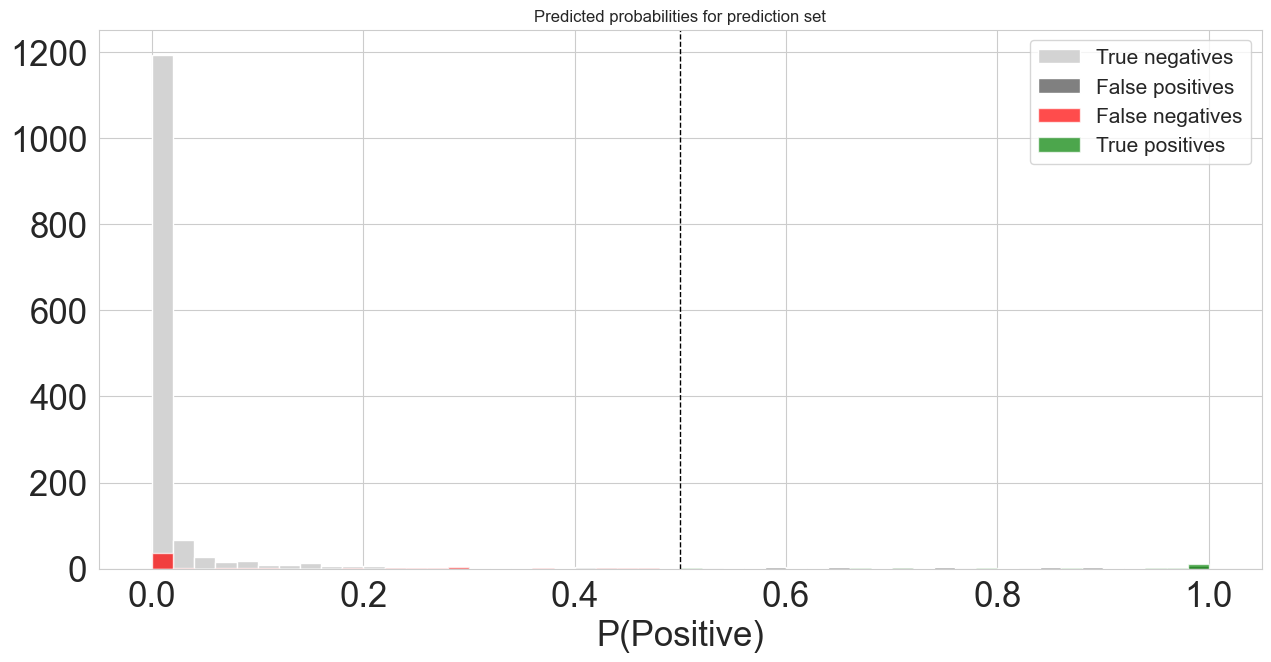

Test P(1) =  4.97%
Test P(1 | predicted 1) =  32.81%
Test P(1 | predicted 0) =  3.74%

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1433
           1       0.33      0.28      0.30        75

    accuracy                           0.94      1508
   macro avg       0.65      0.62      0.63      1508
weighted avg       0.93      0.94      0.93      1508



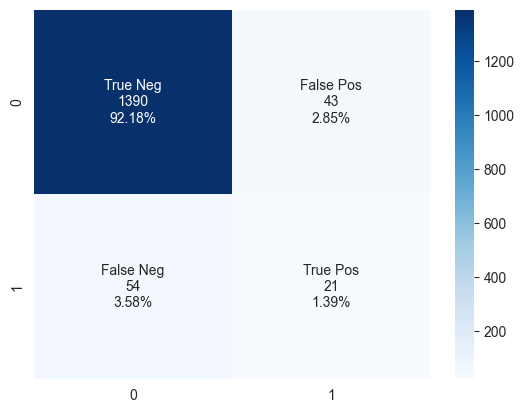

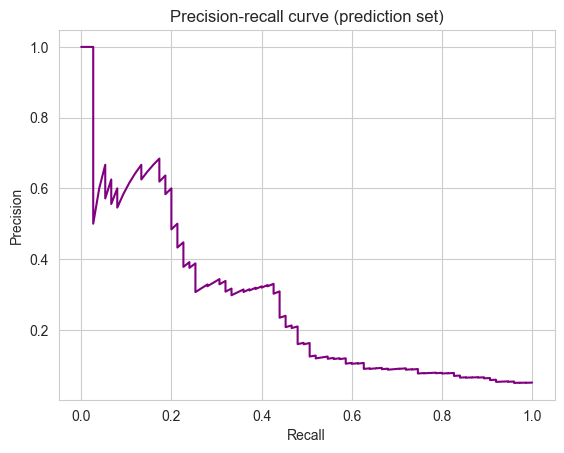

CPU times: user 1min 45s, sys: 30.5 s, total: 2min 15s
Wall time: 32.1 s


In [43]:
%%time

model_description = "Neural network"
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print()

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasClassifier

# set regularization and dropout hyperparameters
l2factor = 0.01
dropoutRate = 0.01
#  use initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
output_bias = Constant(np.log([surveyml.pos_train/surveyml.neg_train]))
# create neural network model
nnmodel = Sequential()
nnmodel.add(Dense(surveyml.num_features, kernel_regularizer=l2(l2factor), activation='relu', input_shape=(surveyml.num_features, )))
nnmodel.add(Dropout(dropoutRate))
nnmodel.add(Dense(surveyml.num_features/2, kernel_regularizer=l2(l2factor), activation='relu'))
nnmodel.add(Dropout(dropoutRate))
nnmodel.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
# compile model
nnmodel.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=[
                    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')])
print(nnmodel.summary())
print()

# create classifier and run model
# classifier_nn = KerasClassifier(nnmodel, epochs=100, batch_size=32, verbose=0, class_weight=surveyml.class_weights)
classifier_nn = KerasClassifier(nnmodel, epochs=40, verbose=0, class_weight=surveyml.class_weights)
predictions = surveyml.run_prediction_model(classifier_nn)

In [45]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

x_outlier_df = surveyml.identify_outliers()

x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 126 (2.0895522388059704%)
CPU times: user 1min 21s, sys: 6.96 s, total: 1min 28s
Wall time: 1min 30s


target,0,1
is_outlier,,
False,0.978958,0.982759
True,0.021042,0.017241
